# Spike Detection/Analysis

In [1]:
using Pkg
using DelimitedFiles
using Statistics
using Dierckx
using Plots #Pkg.add("Plots")

### Directory & Data

In [2]:
                                            # Directory & Data #

cd("C:/voltage_time_data") #location of voltage_time_data
# # # # # # # # # # 

        # Control Data #

control_data = Array{Float64,2}[]
for n in 1:4
    data = readdlm("control$(n).txt", '\t', Float64, '\n', header = false, skipstart = 11)
    push!(control_data, data)
end
return control_data
;

### Plots

In [4]:
                                        # Select a file to plot
file = 4   #file 1-4
trace = 1   #trace 1-5"
spike = 1   #Select an action potential (from left to right 1:n)


fig_size = (1000,600)
line_colour = "black"
peak_colour = "red"
threshold_colour = "blue"
legend_pos = :outerright
;

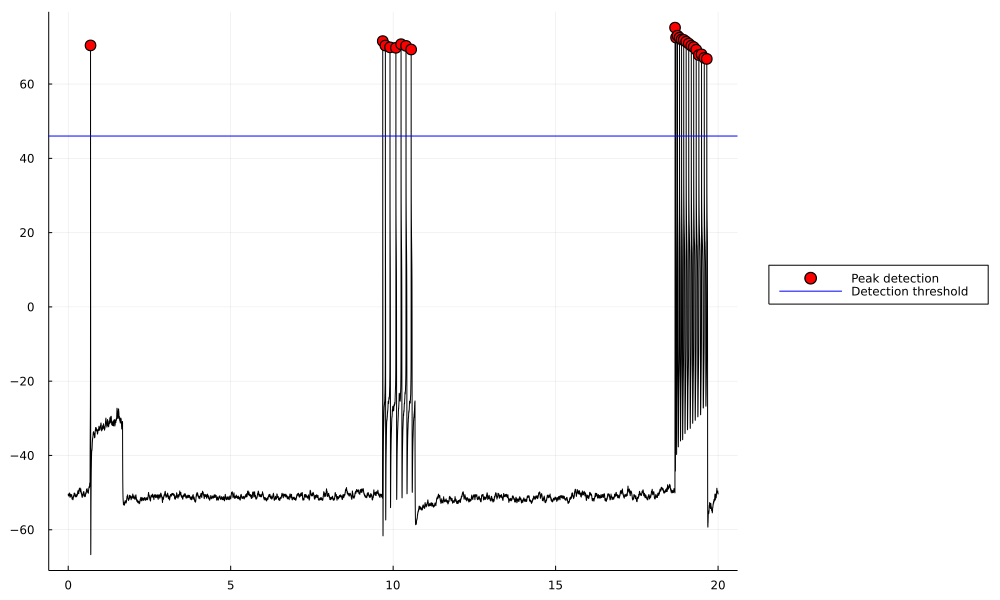

In [5]:
data = control_data[file]
t = data[:,1] #all t values
v = data[:,(trace+1)] #all Vm values for trace
i = peaks(data)[trace] #peak positions

plot(t, v, 
    color = line_colour, 
    size = fig_size, 
    label= "",
    legend = legend_pos)
plot!(t[i], v[i], 
    seriestype =:scatter, 
    color = peak_colour, 
    label="Peak detection", 
    markershapes = :circle, markersize=6)
hline!([threshold], 
    color = threshold_colour, 
    label="Detection threshold")


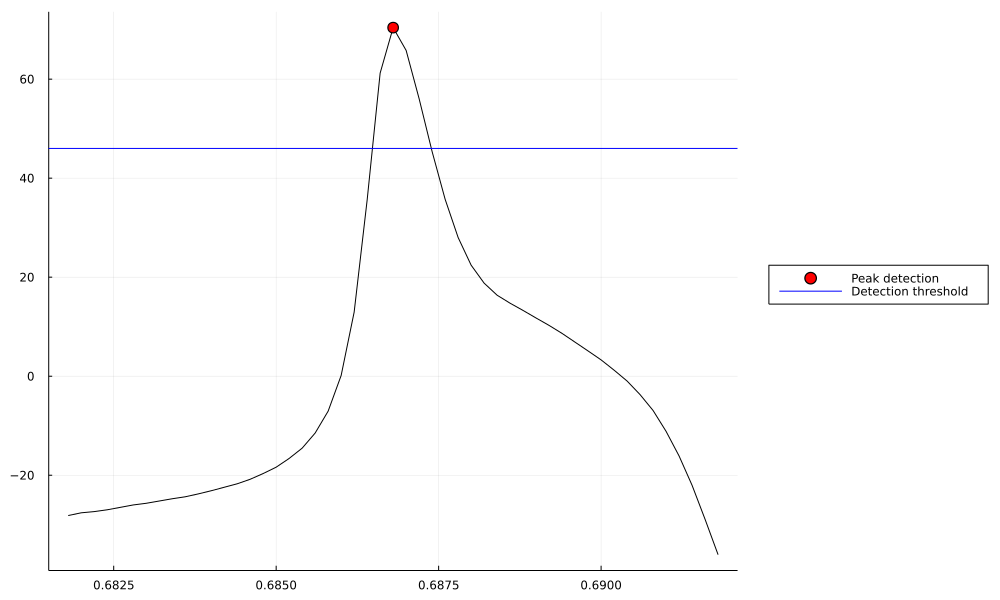

In [6]:
AP1 = AP(t, i[spike]) #indexes of spike


plot(t[AP1], v[AP1], 
    color = line_colour,
    size = fig_size,
    label="",
    legend = legend_pos)
plot!([t[i[spike]]], [v[i[spike]]], 
    seriestype =:scatter, 
    color = peak_colour, 
    label="Peak detection", 
    markershapes = :circle, markersize=6)

hline!([threshold], 
    color = threshold_colour, 
    label="Detection threshold")

## Functions

In [3]:
                                                    # Spline # 
#= edits
10/07/19
- Changed function to produce full data set
- removed t,v arguments and included them within function to generalise
- removed dvdt and peak calculations
=#
function Splines(data, n) #Creates interpolated data using the spline method
    #n = desired number of increments between two (originally) adjacent time points
    t = data[:,1] #all t values
    v1 = data[:,2] #all v values for trace 1
    v2 = data[:,3] #all v values for trace 2
    v3 = data[:,4] #all v values for trace 3
    v4 = data[:,5] #all v values for trace 4
    v5 = data[:,6] #all v values for trace 5
    
    dt = t[2]-t[1] #original increment
    last = t[end] #last t value
    ts = collect(0.0:(dt/n):last) #new t values with interpolated data 
    #=
        Spline1D function from:
        https://github.com/kbarbary/Dierckx.jl
    =#
    #spl(value) Evaluates the spline at some new points:
    spl1 = Spline1D(t,v1)
    spl2 = Spline1D(t,v2)
    spl3 = Spline1D(t,v3)
    spl4 = Spline1D(t,v4)
    spl5 = Spline1D(t,v5)
    
    #new traces with interpolated data
    v1 = spl1(ts) 
    v2 = spl2(ts) 
    v3 = spl3(ts) 
    v4 = spl4(ts) 
    v5 = spl5(ts) 
    
    data = [ts v1 v2 v3 v4 v5]
    
    return data  #all data with interpolation
    
end
# # # # # # # 

                                                # Peak positions #
#= edits 
9/07/19:
- generalised dt to t[2]-t[1]
- Original dvdt can be used to successfully locate the peaks therefore no need to update to the derivative 
function from Dierckx.Pkg
12/07/19
- generalised peaks to return for all traces and data
=#
function peaks(data) #Takes data and returns peak indices for each trace
    t = data[:,1] #all t values
    peak_indices = Array{Int64,1}[]
    
    for n in 2:6
        v = data[:,n] #all Vm values for trace
        
        dt = (t[2]-t[1])*1000 #t[2] is the increment in sec, therefore, *1000 to get ms
        dvdt = diff(v)/dt #dt is the time step in ms. Final units are mV/ms
        
# Tests #
        threshold_Test = v[8:end-1].>threshold #Threshold defined at the very bottom of this cell
        
    # Positive Gradients #
        positive1 = dvdt[1:end-7].>0 #1st gradient = positive
        positive2 = dvdt[2:end-6].>0 
        positive3 = dvdt[3:end-5].>0 
        positive4 = dvdt[4:end-4].>0 
        positive5 = dvdt[5:end-3].>0 
        positive6 = dvdt[6:end-2].>0 
        positive7 = dvdt[7:end-1].>0 
        
    # Negative Gradient #
        negative1 = dvdt[8:end].<=0 #last gradient = negative or 0
        #negative2 = dvdt[9:end].<=0
        
        test = findall(threshold_Test
            .&positive1.&positive2.&positive3.&positive4.&positive5.&positive6.&positive7
            .&negative1) #Finds each point that satisfies the tests above
        
        i = test.+7 #The correct indices for t and v
        
# # # # # 
        #check the difference between each peak index
        minDifference = 6/dt # number of indices for 6 ms

        #closeCount = 1
        #Add while(closeCount>0) (if multiple false peaks near single true peak)
        index1 = i[1:end-1] 
        index2 = i[2:end]
        difference = index2.-index1
        closePeaks = findall(difference.<=minDifference) #return peak number

        closeCount = length(closePeaks)
        for p in 1:closeCount
            closePeaks = [closePeaks[p];closePeaks[p].+1] #Both peaks that are too close

            # Test for largest Vm out of close peaks
            voltageIndex = i[closePeaks] # Original index to check Vm with
            remove = findmin(v[voltageIndex])[2] # Return(index) of lowest Vm
            remove_i = closePeaks[remove] # Desired peak index to remove
            splice!(i, remove_i) #Remove false peak!
        end
# # # # # 
        
        push!(peak_indices, i)
    end
    return peak_indices
end
# # # # # # # 

                                            # Single Action Potential #
#= edits 
12/07/19:
- changed argument to data
24/07/19
- removed ms as argument (set 5ms either side as default)
=#
function AP(data,i) #takes data and the desired index(i) and returns 5 miliseconds either side (to get the whole AP)
    t = data[:,1] #all t values
    dt = (t[2]-t[1])*1000 #t[2] is the increment in sec, therefore, *1000 to get ms
    n = 5/dt #number of indices either side of the peak
    index = collect(Int64,i-n:i+n) #array index
    return(index)
end
# # # # # # # 

                                                    # AP plot #
#= edits 
12/07/19:
- updated peaks
23/10/21
- fixed plots to work with Plots.jl
=#
function plotAP(data, trace, peak_n) #takes trace (1,2,etc) and desired peak (n) and returns plot of desired peak
    # Data #
    t = data[:,1] #all t values
    v = data[:,(trace+1)] #all Vm values for trace
    
    # Original data Plot #
    i = peaks(data)[trace]
    AP1 = AP(t, i[peak_n])
    plot(t[AP1], v[AP1], color = "black")
    plot!([t[i[peak_n]]], [v[i[peak_n]]], color = "red", seriestype =:scatter)
    #title("Original Action Potential", fontsize=16)
    #xlabel("time (s)")
    #ylabel("Membrane Voltage (mV)")
    
end
# # # # # # #

                                                    # Rheobase #
#= edits
12/07/19:
- Extended each rheobase
=#

function rheo(t) #Returns indices of rheobase levels
    dt = t[2]-t[1] #time increment
    L = Int(round(1/dt))+1 #= number of indices which span 1 sec.
    rounded to prevent Inexacterror
    +1 so both first and last (0.67:1.67) t values are given below
    =#
    
    # Getting indices of Rheobase levels #
    
    #(start points from protocol/trace)
    x1 = 0.67 #1x rheobase start point. 0.67:1.67
    x2 = 9.67 #2x rheobase start point. 9.67:10.67
    x5 = 18.67 #5x rheobase start point. 18.67:19.67
    
    start = searchsorted(t, x1)[1] #binary search for start index of 1x rheobase
    #without [1] returns number:number. With [1] returns number
    x1 = range(start, length=L) #t indices of 1x rheobase

    start = searchsorted(t, x2)[1] #start index of 2x rheobase
    x2 = range(start, length=L) #t indices of 2x rheobase

    start = searchsorted(t, x5)[1] #start index of 5x rheobase
    x5 = range(start, length=L) #t indices of 5x rheobase
    
# Extending range of rheobase #
    x = [x1,x2,x5]

    add_time = 0.030 #desired time to add to each side of rheobase (sec)

    for r in 1:3
        # Select rheobase #
        rheobase = x[r]

        extension_indices = Int64(add_time/dt) #translate to indices
        x[r] = rheobase[1]-extension_indices : rheobase[end]+extension_indices
    end

    return x
end
# # # # # # #

                                                    # Baseline #
#= edits
25/07/19:
- Changed output to alltracermp
=#
function rmp(data) #Returns the mean baseline for each trace
    t = data[:,1] #all t values
    v1 = data[:,2] #all v values for trace 1
    v2 = data[:,3] #all v values for trace 2
    v3 = data[:,4] #all v values for trace 3
    v4 = data[:,5] #all v values for trace 4
    v5 = data[:,6] #all v values for trace 5
    
    # Rheobase indices
    x1 = rheo(t)[1] #1x rheobase 
    x2 = rheo(t)[2] #2x rheobase
    
    # Baseline #
    dt = t[2]-t[1] #time increment
    n = Int(round(0.005/dt)) #number of indices which span 5ms
    start = x1[end]+n #5ms ahead of 1x rheobase
    L = Int(round(7.99/dt))+1 #number of indices spanning 7.99sec (between 1x and 2x)
    i = range(start, step=1, length = L) #The indices of this region
    
    Trace1 = mean(v1[i]) #average Vm between 1x and 2x rheobase
    Trace2 = mean(v2[i]) #average Vm between 1x and 2x rheobase
    Trace3 = mean(v3[i]) #average Vm between 1x and 2x rheobase
    Trace4 = mean(v4[i]) #average Vm between 1x and 2x rheobase
    Trace5 = mean(v5[i]) #average Vm between 1x and 2x rheobase
   
    allTraceRMP = [Trace1; Trace2; Trace3; Trace4; Trace5]
    
    Baseline = mean(allTraceRMP) #Overall mean RMP
    #print("Mean RMP = ", Baseline,'\n','\n')
    
    return allTraceRMP #[rmp Trace1,Trace2,Trace3,Trace4,Trace5]
end
# # # # # # #

                                                    # All Amplitudes #
#= edits
12/07/19
- updated peaks
- return all amplitudes instead of mean
- changed variable names
25/07/19
- updated rmp
=#
function allAmp(data) #Returns all amplitudes (rows = Trace, column = rheobase)
    t = data[:,1] #all time values
    All_Trace = [ #all Vm values for each Trace
        data[:,2], 
        data[:,3],
        data[:,4],
        data[:,5],
        data[:,6]
        ]
    
    # Rheobase indices
    x1 = rheo(t)[1] #1x rheobase 
    x2 = rheo(t)[2] #2x rheobase
    x5 = rheo(t)[3] #5x rheobase
    
    x = [x1,x2,x5]
    
    # 'Empty' array of all amplitudes for each rheobase
    all_amplitudes = fill(0.0, 5,3)
    
# Sort amplitudes into Trace and rheobase #
    
# Trace #
    Number_of_Traces = 1:length(All_Trace)
    for n in Number_of_Traces
        # Select Trace #
        Trace = All_Trace[n] #all Vm values of one trace
        
        Trace_baseline = rmp(data)[n] #rmp[2] returns baseline for each Trace
        all_peak_indices = peaks(data)[n] #indices of all peaks  
        
# Rheobase #
        Number_of_rheobases = 1:length(x)
        for r in Number_of_rheobases #r = rheobase x1,x2,x5
            # Select rheobase #
            rheobase_Range = x[r] #range of indices for this rheobase
            
            first_peak = findfirst(in(rheobase_Range), all_peak_indices) #first peak in x rheobase
            if first_peak!==nothing
                # Amplitude calculation #
                Trace_index = all_peak_indices[first_peak] #translate first peak into trace index
                first_Vm = Trace[Trace_index]
                first_amplitude = first_Vm-Trace_baseline #amplitude of first peak in x rheobase

                all_amplitudes[n, r] = first_amplitude
            end
        end
    end
    all_amplitudes = replace(all_amplitudes, 0.0=>missing) #replace all 'empty' elements with missing
    
    return all_amplitudes
end
# # # # # # #

                                            # Mean amplitude #

function meanAmp(data) #returns mean amplitude for each rheobase (Trace = repeats)
    allAmplitudes = allAmp(data)
    mean_x1_amplitude = mean(skipmissing(allAmplitudes[:,1]))
    mean_x2_amplitude = mean(skipmissing(allAmplitudes[:,2]))
    mean_x5_amplitude = mean(skipmissing(allAmplitudes[:,3]))
    mean_amplitudes = [mean_x1_amplitude mean_x2_amplitude mean_x5_amplitude]
    
    return mean_amplitudes
end
# # # # # # #

                                        # Half-width calculation #
function halfwidth(data) #returns
    t = data[:,1] #all time values
    All_Trace = [ #all Vm values for each Trace
        data[:,2], 
        data[:,3],
        data[:,4],
        data[:,5],
        data[:,6]]
    
    # Rheobase indices
    x1 = rheo(t)[1] #1x rheobase 
    x2 = rheo(t)[2] #2x rheobase
    x5 = rheo(t)[3] #5x rheobase
    x = [x1,x2,x5]
    
    # 'Empty' array of all half widths for each rheobase
    all_halfwidth = fill(0.0, 5,3)
    
# Sort half-widths into Trace and rheobase #
    amplitudes = allAmp(data)
# Trace #
    Number_of_Traces = 1:length(All_Trace)
    for n in Number_of_Traces
        # Select Trace #
        Trace = All_Trace[n] #all Vm values of one trace
        all_peak_indices = peaks(data)[n] #indices of all peaks  
        
# Rheobase #
        Number_of_rheobases = 1:length(x)
        for r in Number_of_rheobases #r = rheobase x1,x2,x5
            # Select rheobase #
            rheobase_Range = x[r] #range of indices for this rheobase
            
            first_peak = findfirst(in(rheobase_Range), all_peak_indices) #first peak in x rheobase
            if first_peak!==nothing
                # Amplitude calculation #
                Trace_index = all_peak_indices[first_peak] #translate first peak into trace index
                wholeAP = AP(data, Trace_index) #indices of whole AP
                halfAmp = amplitudes[n,r]/2
                halfpoint = Trace[Trace_index] - halfAmp #half amplitude ralative to peak/baseline
                
                #Return indices >= half amplitude
                i = findall(Trace[wholeAP].>=halfpoint)
                trace_i = wholeAP[i] #translate into trace index
                first = trace_i[1] #first halfamp index
                last = trace_i[end].+1 #last halfamp index
                half_width = t[last]-t[first]
                
                all_halfwidth[n, r] = half_width
            end
        end
    end
    all_halfwidth = replace(all_halfwidth, 0.0=>missing) #replace all 'empty' elements with missing
    
end
# # # # # # #
                                            # Mean half-width #

function meanwidth(data) #returns mean halfwidth for each rheobase (Trace = repeats)
    allWidths = halfwidth(data)
    mean_x1_halfwidth = mean(skipmissing(allWidths[:,1]))
    mean_x2_halfwidth = mean(skipmissing(allWidths[:,2]))
    mean_x5_halfwidth = mean(skipmissing(allWidths[:,3]))
    mean_halfwidths = [mean_x1_halfwidth mean_x2_halfwidth mean_x5_halfwidth]
    
    return mean_halfwidths
end
# # # # # # #
                                        # Number of Action Potentials #

function apCount(data) #Returns the number of action potentials (rows = Trace, column = rheobase)
    t = data[:,1] #all time values
    All_Trace = [ #all Vm values for each Trace
        data[:,2], 
        data[:,3],
        data[:,4],
        data[:,5],
        data[:,6]
        ]
    
    # Rheobase indices
    x1 = rheo(t)[1] #1x rheobase 
    x2 = rheo(t)[2] #2x rheobase
    x5 = rheo(t)[3] #5x rheobase
    
    x = [x1,x2,x5]
    
    # 'Empty' array
    ap_Counts = fill(0, 5,3)
    
# Sort AP counts into Trace and rheobase #
    
# Trace #
    Number_of_Traces = 1:length(All_Trace)
    for n in Number_of_Traces
        # Select Trace #
        Trace = All_Trace[n] #all Vm values of one trace
        
        all_peak_indices = peaks(data)[n] #indices of all peaks  
        
# Rheobase #
        Number_of_rheobases = 1:length(x)
        for r in Number_of_rheobases #r = rheobase x1,x2,x5
            # Select rheobase #
            rheobase_Range = x[r] #range of indices for this rheobase
            
            count = 0
            
            rheobase_Peaks = findall(in(rheobase_Range), all_peak_indices) #All peaks in x rheobase
            if rheobase_Peaks!==nothing #if >0 peaks exist
                
                count = length(rheobase_Peaks)

                ap_Counts[n, r] = count
            end
        end
    end
    
    return ap_Counts
end
# # # # # # #

                                    # Mean number of action potentials #

function meanCounts(data)
    x1Count = mean(apCount(data)[:,1])
    x2Count = mean(apCount(data)[:,2])
    x5Count = mean(apCount(data)[:,3])
    
    mean_Counts = [x1Count x2Count x5Count]
    return mean_Counts
end
# # # # # # #

                                            # All Overshoot #

function overshoot(data) #Returns all overshoots (rows = Trace, column = rheobase)
    t = data[:,1] #all time values
    All_Trace = [ #all Vm values for each Trace
        data[:,2], 
        data[:,3],
        data[:,4],
        data[:,5],
        data[:,6]]
    
    # Rheobase indices
    x1 = rheo(t)[1] #1x rheobase 
    x2 = rheo(t)[2] #2x rheobase
    x5 = rheo(t)[3] #5x rheobase
    x = [x1,x2,x5]
    
    # 'Empty' array of all overshoots for each rheobase
    all_overshoot = fill(0.0, 5,3)
    
# Sort overshoots into Trace and rheobase #
    
# Trace #
    Number_of_Traces = 1:length(All_Trace)
    for n in Number_of_Traces
        # Select Trace #
        Trace = All_Trace[n] #all Vm values of one trace
        
        all_peak_indices = peaks(data)[n] #indices of all peaks  
        
# Rheobase #
        Number_of_rheobases = 1:length(x)
        for r in Number_of_rheobases #r = rheobase x1,x2,x5
            # Select rheobase #
            rheobase_Range = x[r] #range of indices for this rheobase
            
            first_peak = findfirst(in(rheobase_Range), all_peak_indices) #first peak in x rheobase
            if first_peak!==nothing
                # Overshoot calculation #
                Trace_index = all_peak_indices[first_peak] #translate first peak into trace index

                all_overshoot[n, r] = Trace[Trace_index] #Trace[Trace_index] gives overshoot
            end
        end
    end
    all_overshoot = replace(all_overshoot, 0.0=>missing) #replace all 'empty' elements with missing
    
    return all_overshoot
end
# # # # # # #

                                            # Mean Overshoot #

function meanOvershoot(data) #returns mean overshoot for each rheobase (Trace = repeats)
    allovershoots = overshoot(data)
    mean_x1_overshoot = mean(skipmissing(allovershoots[:,1]))
    mean_x2_overshoot = mean(skipmissing(allovershoots[:,2]))
    mean_x5_overshoot = mean(skipmissing(allovershoots[:,3]))
    mean_overshoots = [mean_x1_overshoot mean_x2_overshoot mean_x5_overshoot]
    
    return mean_overshoots
end
# # # # # # #


# Action potential detection threshold (mV) #
threshold = 46 #mV
;